# Introduction

<div class="alert alert-block alert-warning">
<font color=black><br>

**What?** How to Make Out-of-Sample Forecasts with ARIMA

<br></font>
</div>

# Import modules

In [37]:
from pandas import read_csv
from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Import dataset

<div class="alert alert-block alert-info">
<font color=black><br>

- This dataset describes the minimum daily temperatures over 10 years (1981-1990) in the city of Melbourne, Australia.
- The units are in degrees Celsius and there are 3,650 observations. 
- You can see how the dataset is not stationary becase it has a strong seasonal component.
- You may be wondering that the mean is constant in this seasonal time series so **why not considering** it as stationary? This is because seasonality affects the value of the time series at different times. On the other hand, a **white noise** series is stationary — it does not matter when you observe it, it should look much the same at any point in time.

<br></font>
</div>

In [7]:
series = read_csv('../DATASETS/daily-min-temperatures.csv', header=0, index_col=0)
print(series.head(1000))

            Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
1981-01-04  14.6
1981-01-05  15.8
...          ...
1983-09-23  12.9
1983-09-24   7.7
1983-09-25   7.6
1983-09-26   3.5
1983-09-27  10.4

[1000 rows x 1 columns]


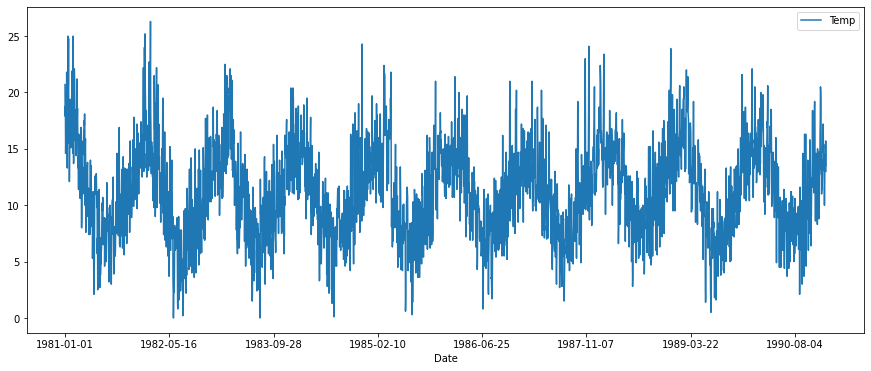

In [11]:
rcParams['figure.figsize'] = 15, 6
rcParams['font.size'] = 10
series.plot()
pyplot.show()

# Split the dataset

<div class="alert alert-block alert-info">
<font color=black><br>

- We will hold back the last 7 days of the dataset from December 1990 as the test dataset and treat those time steps as out of sample.

<br></font>
</div>

In [12]:
split_point = len(series) - 7
dataset, validation = series[0:split_point], series[split_point:]

In [13]:
dataset

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8
...,...
1990-12-20,15.4
1990-12-21,13.1
1990-12-22,13.2


In [14]:
validation

,Temp
Date,
1990-12-25,12.9
1990-12-26,14.6
1990-12-27,14.0
1990-12-28,13.6
1990-12-29,13.5
1990-12-30,15.7
1990-12-31,13.0


# Modelling

<div class="alert alert-block alert-info">
<font color=black><br>

- We are going to make the data stationary by removing the seasonal component by taking the seasonal difference. 
- **In practice**, we can take the observation for a day and subtract the observation from the same day one year ago.
- We then fot a simple ARIMA model. Its hyperparameters can be optimised.

<br></font>
</div>

In [20]:
def difference(dataset, interval=1):
    """Create a differenced series"""
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)

In [21]:
def inverse_difference(history, yhat, interval=1):
    """Invert differenced value"""
    return yhat + history[-interval]

In [24]:
X = series.values
days_in_year = 365
differenced = difference(X, days_in_year)
differenced

array([[-3.7],
       [-2.9],
       [-5.3],
       ...,
       [ 3.1],
       [ 1.3],
       [ 0.3]])

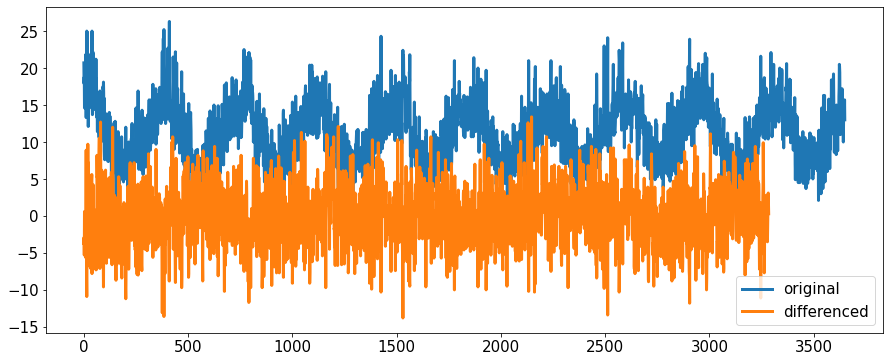

In [35]:
rcParams['figure.figsize'] = 15, 6
rcParams['font.size'] = 15
plt.plot(range(len(X)), X, lw = 3, label = "original")
plt.plot(range(len(differenced)), differenced, lw = 3, label = "differenced")
plt.legend()
plt.show()

In [39]:
# Fitting
model = ARIMA(differenced, order=(7,0,1))
model_fit = model.fit()

In [40]:
# Print summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3285
Model:                 ARIMA(7, 0, 1)   Log Likelihood               -8689.286
Date:                Fri, 17 Sep 2021   AIC                          17398.571
Time:                        10:25:51   BIC                          17459.542
Sample:                             0   HQIC                         17420.401
                               - 3285                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0152      0.132      0.115      0.909      -0.244       0.275
ar.L1          1.1442      0.314      3.642      0.000       0.528       1.760
ar.L2         -0.4358      0.168     -2.594      0.0

# Out-of-sample forecast

<div class="alert alert-block alert-info">
<font color=black><br>

- Let's now predict the next 7 days **out-of-sample** forecast.

<br></font>
</div>

In [101]:
forecast = model_fit.forecast(steps = 1)
forecast

array([0.07277459])

3284


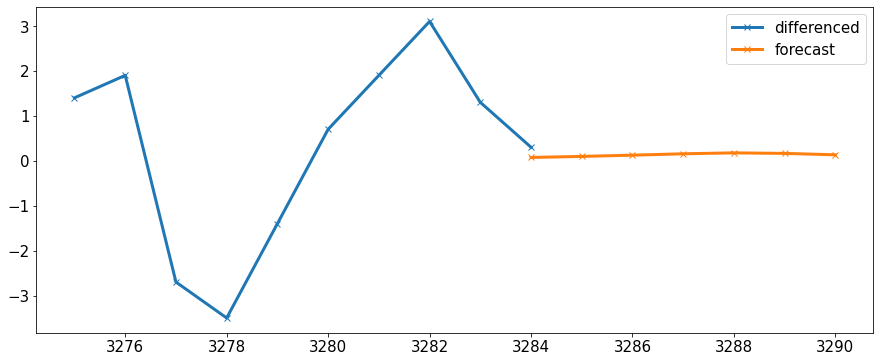

In [94]:
rcParams['figure.figsize'] = 15, 6
rcParams['font.size'] = 15
plt.plot(list(range(len(differenced)))[-10:], differenced[-10:], "x-", lw = 3, label = "differenced")

dummy = [i + list(range(len(differenced)))[-10:][-1] for i in range(len(forecast))]
plt.plot(dummy, forecast , "x-", lw = 3, label = "forecast")

plt.legend()
plt.show()

# Multiple out-of-sample forecast

<div class="alert alert-block alert-info">
<font color=black><br>

- A one-step forecast is a forecast of the **very next time step** in the sequence from the available data used to fit the model.
- In ARIMA you have two options:
    - **forecast()** = By default, this function makes a single step out-of-sample forecast. As such, we can call it directly and make our forecast. The result of the forecast() function is an array containing the forecast value, the standard error of the forecast, and the confidence interval information. 
    - **predict()** = the predict function can be used to predict arbitrary **in-sample** and **out-of-sample** time steps.
- We'll try to predict the next 7 days temperature.
    
<br></font>
</div>

In [99]:
# multi-step out-of-sample forecast
forecast = model_fit.forecast(steps=7)
# invert the differenced forecast to something usable
history = [x for x in X]
day = 1
for yhat in forecast:
    inverted = inverse_difference(history, yhat, days_in_year)
    print('Day %d: %f' % (day, inverted))
    history.append(inverted)
    day += 1

Day 1: 14.872775
Day 2: 13.396241
Day 3: 15.723841
Day 4: 14.654581
Day 5: 14.475347
Day 6: 15.463134
Day 7: 16.531773


In [96]:
# multi-step out-of-sample forecast
start_index = len(differenced)
end_index = start_index + 6
forecast = model_fit.predict(start=start_index, end=end_index)
# invert the differenced forecast to something usable
history = [x for x in X]
day = 1
for yhat in forecast:
    inverted = inverse_difference(history, yhat, days_in_year)
    print('Day %d: %f' % (day, inverted))
    history.append(inverted)
    day += 1

Day 1: 14.872775
Day 2: 13.396241
Day 3: 15.723841
Day 4: 14.654581
Day 5: 14.475347
Day 6: 15.463134
Day 7: 16.531773


# References

<div class="alert alert-block alert-warning">
<font color=black><br>

- https://machinelearningmastery.com/make-sample-forecasts-arima-python/
- [Download dataset](https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv)
    
<br></font>
</div>